In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyemu
import flopy


from math import log10
from math import sqrt
import shutil

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
org_model_ws = os.path.join('..', 'experimental')
model_ws = os.path.join('..', 'experimental_ppoints')

sim = flopy.mf6.MFSimulation.load(sim_ws=org_model_ws)
m = sim.get_model()

sim.set_sim_path(model_ws)

sim.write_simulation()

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package obs...
    loading package sfr...
    loading package rch...
    loading package ghb...
    loading package sto...
    loading package oc...
    loading package npf...
    loading package ic...
  loading ims package experimental...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package experimental...
  writing model experimental...
    writing model name file...
    writing package disv...
    writing package gwf_obs...
    writing package sfr_obs...
    writing package sfr...
    writing package rch...
    writing package ghb...
    writing package sto...
    writing package oc...
    writing package npf...
    writing package ic...


In [4]:
cell_coords = list(zip(m.modelgrid.xcellcenters, m.modelgrid.ycellcenters))

# set a ppoint at evey nth cell:
nth = 5
ppoints = pd.DataFrame(cell_coords[::nth], columns=['x','y'])
ppoints['ppname'] = [f'pp{i:04d}' for i in ppoints.index.values]
ppoints[['zone','val']] = 1, 1

ppoints = ppoints[['ppname', 'x', 'y','zone', 'val']]
ppoints.to_csv(os.path.join(model_ws, 'ppoints.dat'), sep='\t', index=False)

ppoints.head()

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ppname,x,y,zone,val
0,pp0000,426895.944,6654902.55,1,1
1,pp0001,426924.228,6654934.37,1,1
2,pp0002,426945.442,6654952.05,1,1
3,pp0003,426980.797,6654987.40,1,1
4,pp0004,427016.152,6655022.76,1,1


c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='x'>

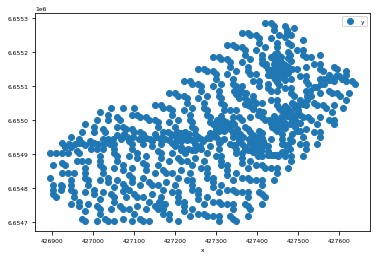

In [14]:
#
ppoints.plot(x='x', y='y', linestyle='', marker='o')


In [6]:
# READ THE MANUAL and/or tutorials to follow what is happening here

from lumpyrem import run
#MKPPSTAT
# mkppstat requires no headers in ppoint file ...sigh...
ppoints.to_csv(os.path.join(model_ws, 'mkppoints.dat'),
                       header=None, index=False, sep='\t')

# Input for MKPPSTAT
npoints = 10
a = 1.2
# run MKPPSTAT
run.run_process('mkppstat', path=model_ws, commands=['mkppoints.dat', npoints, a, 'ppstat.dat'])

# run PPCOV_SVA
run.run_process('ppcov_sva', path=model_ws, commands=['ppstat.dat', 'y', 1, 'x',  'cov.mat', ''])

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 757 pilot points read from pilot points file mkppoints.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ppstat.dat written ok
 

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 757 pilot points read from pilot points file ppstat.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point prefix f

In [7]:
# Load cov mat file with Pyemu for further processing
covmat = pyemu.Cov.from_ascii(os.path.join(model_ws, "cov.mat"))

# This covaraince matrix can now be used as the base for all pilot point parameters. 
# Note that in this case the variance is 1, so it is easy to scale to a parameters prior varaince
# Depending on how you setup the scrpt, variance can be assigned at various stages (i.e. when running PPCOV_SVA, or by manipulating the matrix later)
# Note that parameter names (headers and row names) come from the parameter name sin the ppoint file. These can have a prefix added by PPCOV_SVA, or changed in the dataframe. The latter is more versatile.
covmat.to_dataframe().head()

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pp0000,pp0001,pp0002,pp0003,pp0004,pp0005,pp0006,pp0007,pp0008,pp0009,...,pp0747,pp0748,pp0749,pp0750,pp0751,pp0752,pp0753,pp0754,pp0755,pp0756
pp0000,1.000000,0.312988,0.140840,0.081857,0.028849,0.683772,0.254439,0.131276,0.068153,0.026528,...,1.173461e-06,1.104334e-06,0.000008,0.000002,1.942176e-06,0.000026,0.000006,7.525925e-06,0.000019,1.184458e-05
pp0001,0.312988,1.000000,0.461505,0.120562,0.030824,0.386713,0.578452,0.507458,0.200787,0.052196,...,1.072294e-07,4.231633e-08,0.000002,0.000002,8.799042e-07,0.000002,0.000001,6.906736e-07,0.000001,6.861773e-07
pp0002,0.140840,0.461505,1.000000,0.246612,0.060806,0.182081,0.299486,0.445119,0.412534,0.104625,...,1.220597e-07,4.857244e-08,0.000002,0.000002,9.143945e-07,0.000002,0.000001,7.091294e-07,0.000001,6.841103e-07
pp0003,0.081857,0.120562,0.246612,1.000000,0.352752,0.051360,0.055631,0.075553,0.550162,0.466044,...,6.480234e-06,6.297450e-06,0.000017,0.000006,7.128918e-06,0.000049,0.000016,2.324853e-05,0.000041,3.176866e-05
pp0004,0.028849,0.030824,0.060806,0.352752,1.000000,0.013445,0.009970,0.011725,0.151090,0.582729,...,1.184124e-05,1.191409e-05,0.000018,0.000008,1.017721e-05,0.000053,0.000020,3.163454e-05,0.000047,4.081638e-05


c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


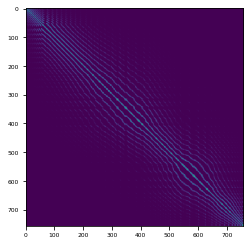

In [8]:
plt.imshow(covmat.as_2d)

In [16]:
run.run_process??

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
